In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 300
K = 3
D = 2

## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 10
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
PATH = 'ag-sis-mu-cf-z'

gpu = torch.device('cuda:0')

In [3]:
Xs = torch.from_numpy(np.load('rings_varying_radius/obs.npy')).float()
# STATES = torch.from_numpy(np.load('rings_dataset/states.npy')).float()
OBS_RAD = torch.from_numpy(np.load('rings_varying_radius/obs_rad.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_mu(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_stats=STAT_SIZE,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        
        self.neural_stats = nn.Sequential(
            nn.Linear(K+D, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, num_stats),
            nn.Tanh())
        self.mean_mu = nn.Sequential(
            nn.Linear(num_stats+D, int(0.5 * num_stats+ 0.5 * D)),
            nn.Tanh(),
            nn.Linear(int(0.5 * num_stats + 0.5 * D), D))
        
        self.mean_log_sigma = nn.Sequential(
            nn.Linear(num_stats+D, int(0.5 * num_stats+ 0.5 * D)),
            nn.Tanh(),
            nn.Linear(int(0.5 * num_stats + 0.5 * D), D))

        self.prior_mu = torch.zeros((K, D))
        self.prior_sigma = torch.ones((K, D)) * 4.0
        if CUDA:
            self.prior_mu = self.prior_mu.cuda().to(gpu)
            self.prior_sigma = self.prior_sigma.cuda().to(gpu)
        
    def forward(self, obs, states, sample_size, batch_size):
        neural_stats = self.neural_stats(torch.cat((obs, states), -1))
        _, _, _, stat_size = neural_stats.shape
        cluster_size = states.sum(-2)  
        cluster_size[cluster_size == 0.0] = 1.0 # S * B * K
        neural_stats_expand = neural_stats.unsqueeze(-1).repeat(1, 1, 1, 1, K).transpose(-1, -2) ## S * B * N * K * STAT_SIZE
        states_expand = states.unsqueeze(-1).repeat(1, 1, 1, 1, stat_size) ## S * B * N * K * STAT_SIZE
        sum_stats = (states_expand * neural_stats_expand).sum(2) ## S * B * K * STAT_SIZE
        mean_stats = sum_stats / cluster_size.unsqueeze(-1)
        
        c1 = torch.cat((self.prior_mu[0].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,0,:]), -1)
        c2 = torch.cat((self.prior_mu[1].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,1,:]), -1)
        c3 = torch.cat((self.prior_mu[2].repeat(batch_size, 1).repeat(sample_size, 1, 1), mean_stats[:,:,2,:]), -1)
        #
        q_mu_c1 = self.mean_mu(c1)
        q_mu_c2 = self.mean_mu(c2)
        q_mu_c3 = self.mean_mu(c3)
        q_sigma_c1 = self.mean_log_sigma(c1).exp()
        q_sigma_c2 = self.mean_log_sigma(c2).exp()
        q_sigma_c3 = self.mean_log_sigma(c3).exp() 
        q_mu = torch.cat((q_mu_c1.unsqueeze(-2), q_mu_c2.unsqueeze(-2), q_mu_c3.unsqueeze(-2)), -2)
        q_sigma = torch.cat((q_sigma_c1.unsqueeze(-2), q_sigma_c2.unsqueeze(-2), q_sigma_c3.unsqueeze(-2)), -2)
        
        q = probtorch.Trace()   
        p = probtorch.Trace()
        means = Normal(q_mu, q_sigma).sample()
        q.normal(q_mu, 
                 q_sigma, 
                 value=means, 
                 name='means')
        p.normal(self.prior_mu, 
                 self.prior_sigma, 
                 value=q['means'], 
                 name='means')    
        return q, p
def initialize():
    enc_mu = Enc_mu()
    if CUDA:
        enc_mu.cuda().to(gpu)
    return enc_mu

In [5]:
enc_mu = initialize()

In [6]:
prior_pi = torch.ones(K) * (1./ K)
if CUDA:
    prior_pi = prior_pi.cuda().to(gpu)
    
def enc_z(obs, obs_mu, obs_rad, sample_size, batch_size, noise_sigma):
    obs_mu_expand = obs_mu.unsqueeze(-2).repeat(1, 1, 1, N, 1) # S * B * K * N * D
    obs_rad_expand = obs_rad.squeeze(-1).unsqueeze(-1).repeat(1, 1, 1, N) # S * B * K * N
    obs_expand = obs.unsqueeze(2).repeat(1, 1, K, 1, 1) #  S * B * K * N * D
    distance = ((obs_expand - obs_mu_expand)**2).sum(-1).sqrt()
    obs_dist = Normal(obs_rad_expand, torch.ones(1).cuda().to(gpu) * noise_sigma)
    log_distance = (obs_dist.log_prob(distance) - (2*math.pi*distance).log()).transpose(-1, -2) # S * B * N * K   

    q_pi = F.softmax(log_distance, -1)
    q = probtorch.Trace()
    p = probtorch.Trace()
    z = cat(q_pi).sample()
    _ = q.variable(cat, probs=q_pi, value=z, name='zs')
    p = probtorch.Trace()
    _ = p.variable(cat, probs=prior_pi, value=z, name='zs')
    return q, p

def Eubo_ag(enc_mu, enc_z, obs, obs_rad, N, K, D, mcmc_size, sample_size, batch_size, gpu, decay_factor, noise_sigma):
    """
    initialize z

    """
    loss = 0.0
    eubos = torch.zeros(mcmc_size).cuda()
    elbos = torch.zeros(mcmc_size).cuda()
    esss = torch.zeros(mcmc_size).cuda()

    p_init_z = cat(prior_pi)
    states = p_init_z.sample((sample_size, batch_size, N,))
    log_p_z = p_init_z.log_prob(states)## S * B * N
    log_q_z = p_init_z.log_prob(states)

    for m in range(mcmc_size):
        q_mu, p_mu = enc_mu(obs, states, sample_size, batch_size)
        log_q_mu = q_mu['means'].log_prob.sum(-1)
        log_p_mu = p_mu['means'].log_prob.sum(-1) # S * B * K
        obs_mu = q_mu['means'].value
        log_obs_k = True_Log_likelihood(obs, states, obs_mu, obs_rad, K, D, noise_sigma=noise_sigma, gpu=gpu, cluster_flag=True)
        log_weights_global = log_obs_k + log_p_mu - log_q_mu
        weights_global = F.softmax(log_weights_global, 0).detach()
        ## resample mu
        obs_mu = resample_mu(obs_mu, weights_global)
        ## update z -- cluster assignments
        q_z, p_z = enc_z(obs, obs_mu, obs_rad, sample_size, batch_size, noise_sigma)
        log_p_z = p_z['zs'].log_prob
        log_q_z = q_z['zs'].log_prob ## S * B * N
        states = q_z['zs'].value
        log_obs_n = True_Log_likelihood(obs, states, obs_mu, obs_rad, K, D, noise_sigma=noise_sigma, gpu=gpu, cluster_flag=False)
        log_weights_local = log_obs_n + log_p_z - log_q_z
        weights_local = F.softmax(log_weights_local, 0).detach()

        eubos[m] =((weights_global * log_weights_global).sum(0).sum(-1).mean() + (weights_local * log_weights_local).sum(0).sum(-1).mean()) / 2
        elbos[m] = (log_weights_global.sum(-1).mean() + log_weights_local.sum(-1).mean()) / 2
        esss[m] = ((1. / (weights_local**2).sum(0)).mean() + (1. / (weights_global**2).sum(0)).mean() ) / 2
    return eubos, elbos, esss

In [7]:
optimizer =  torch.optim.Adam(list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    

EUBOs = []
ELBOs = []
ESSs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
for epoch in range(100):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs_rad = OBS_RAD[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs = obs.cuda().to(gpu)
            obs_rad = obs_rad.cuda().to(gpu)
        eubos, elbos, esss = Eubo_ag(enc_mu, enc_z, obs, obs_rad, N, K, D, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, gpu, decay_factor=0, noise_sigma=0.05)
        ## gradient step
        eubos.mean().backward()
        optimizer.step()
        EUBO += eubos[-1].item()
        ELBO += elbos[-1].item()
        ESS += esss[-1].item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               time_end - time_start))


epoch=0, EUBO=-114759.543, ELBO=-280034.868, ESS=5.492 (21s)
epoch=1, EUBO=-63804.137, ELBO=-140081.458, ESS=5.499 (21s)
epoch=2, EUBO=-45875.051, ELBO=-79136.198, ESS=5.498 (21s)
epoch=3, EUBO=-36051.422, ELBO=-57728.202, ESS=5.497 (21s)
epoch=4, EUBO=-31639.064, ELBO=-47219.251, ESS=5.495 (21s)
epoch=5, EUBO=-28824.004, ELBO=-40533.000, ESS=5.491 (21s)
epoch=6, EUBO=-25729.893, ELBO=-35283.682, ESS=5.492 (21s)
epoch=7, EUBO=-28562.870, ELBO=-36525.355, ESS=5.490 (21s)
epoch=8, EUBO=-28221.527, ELBO=-34843.353, ESS=5.484 (20s)
epoch=9, EUBO=-27997.335, ELBO=-33646.770, ESS=5.488 (20s)
epoch=10, EUBO=-26806.508, ELBO=-32059.578, ESS=5.487 (21s)
epoch=11, EUBO=-27147.342, ELBO=-31879.095, ESS=5.485 (20s)
epoch=12, EUBO=-26739.953, ELBO=-30927.090, ESS=5.484 (20s)
epoch=13, EUBO=-26499.372, ELBO=-30415.362, ESS=5.478 (20s)
epoch=14, EUBO=-26316.126, ELBO=-29908.260, ESS=5.481 (20s)
epoch=15, EUBO=-25616.780, ELBO=-29076.704, ESS=5.486 (21s)
epoch=16, EUBO=-26228.802, ELBO=-29431.592, ESS

KeyboardInterrupt: 

CPU times: user 4.27 s, sys: 12 ms, total: 4.28 s
Wall time: 4.28 s


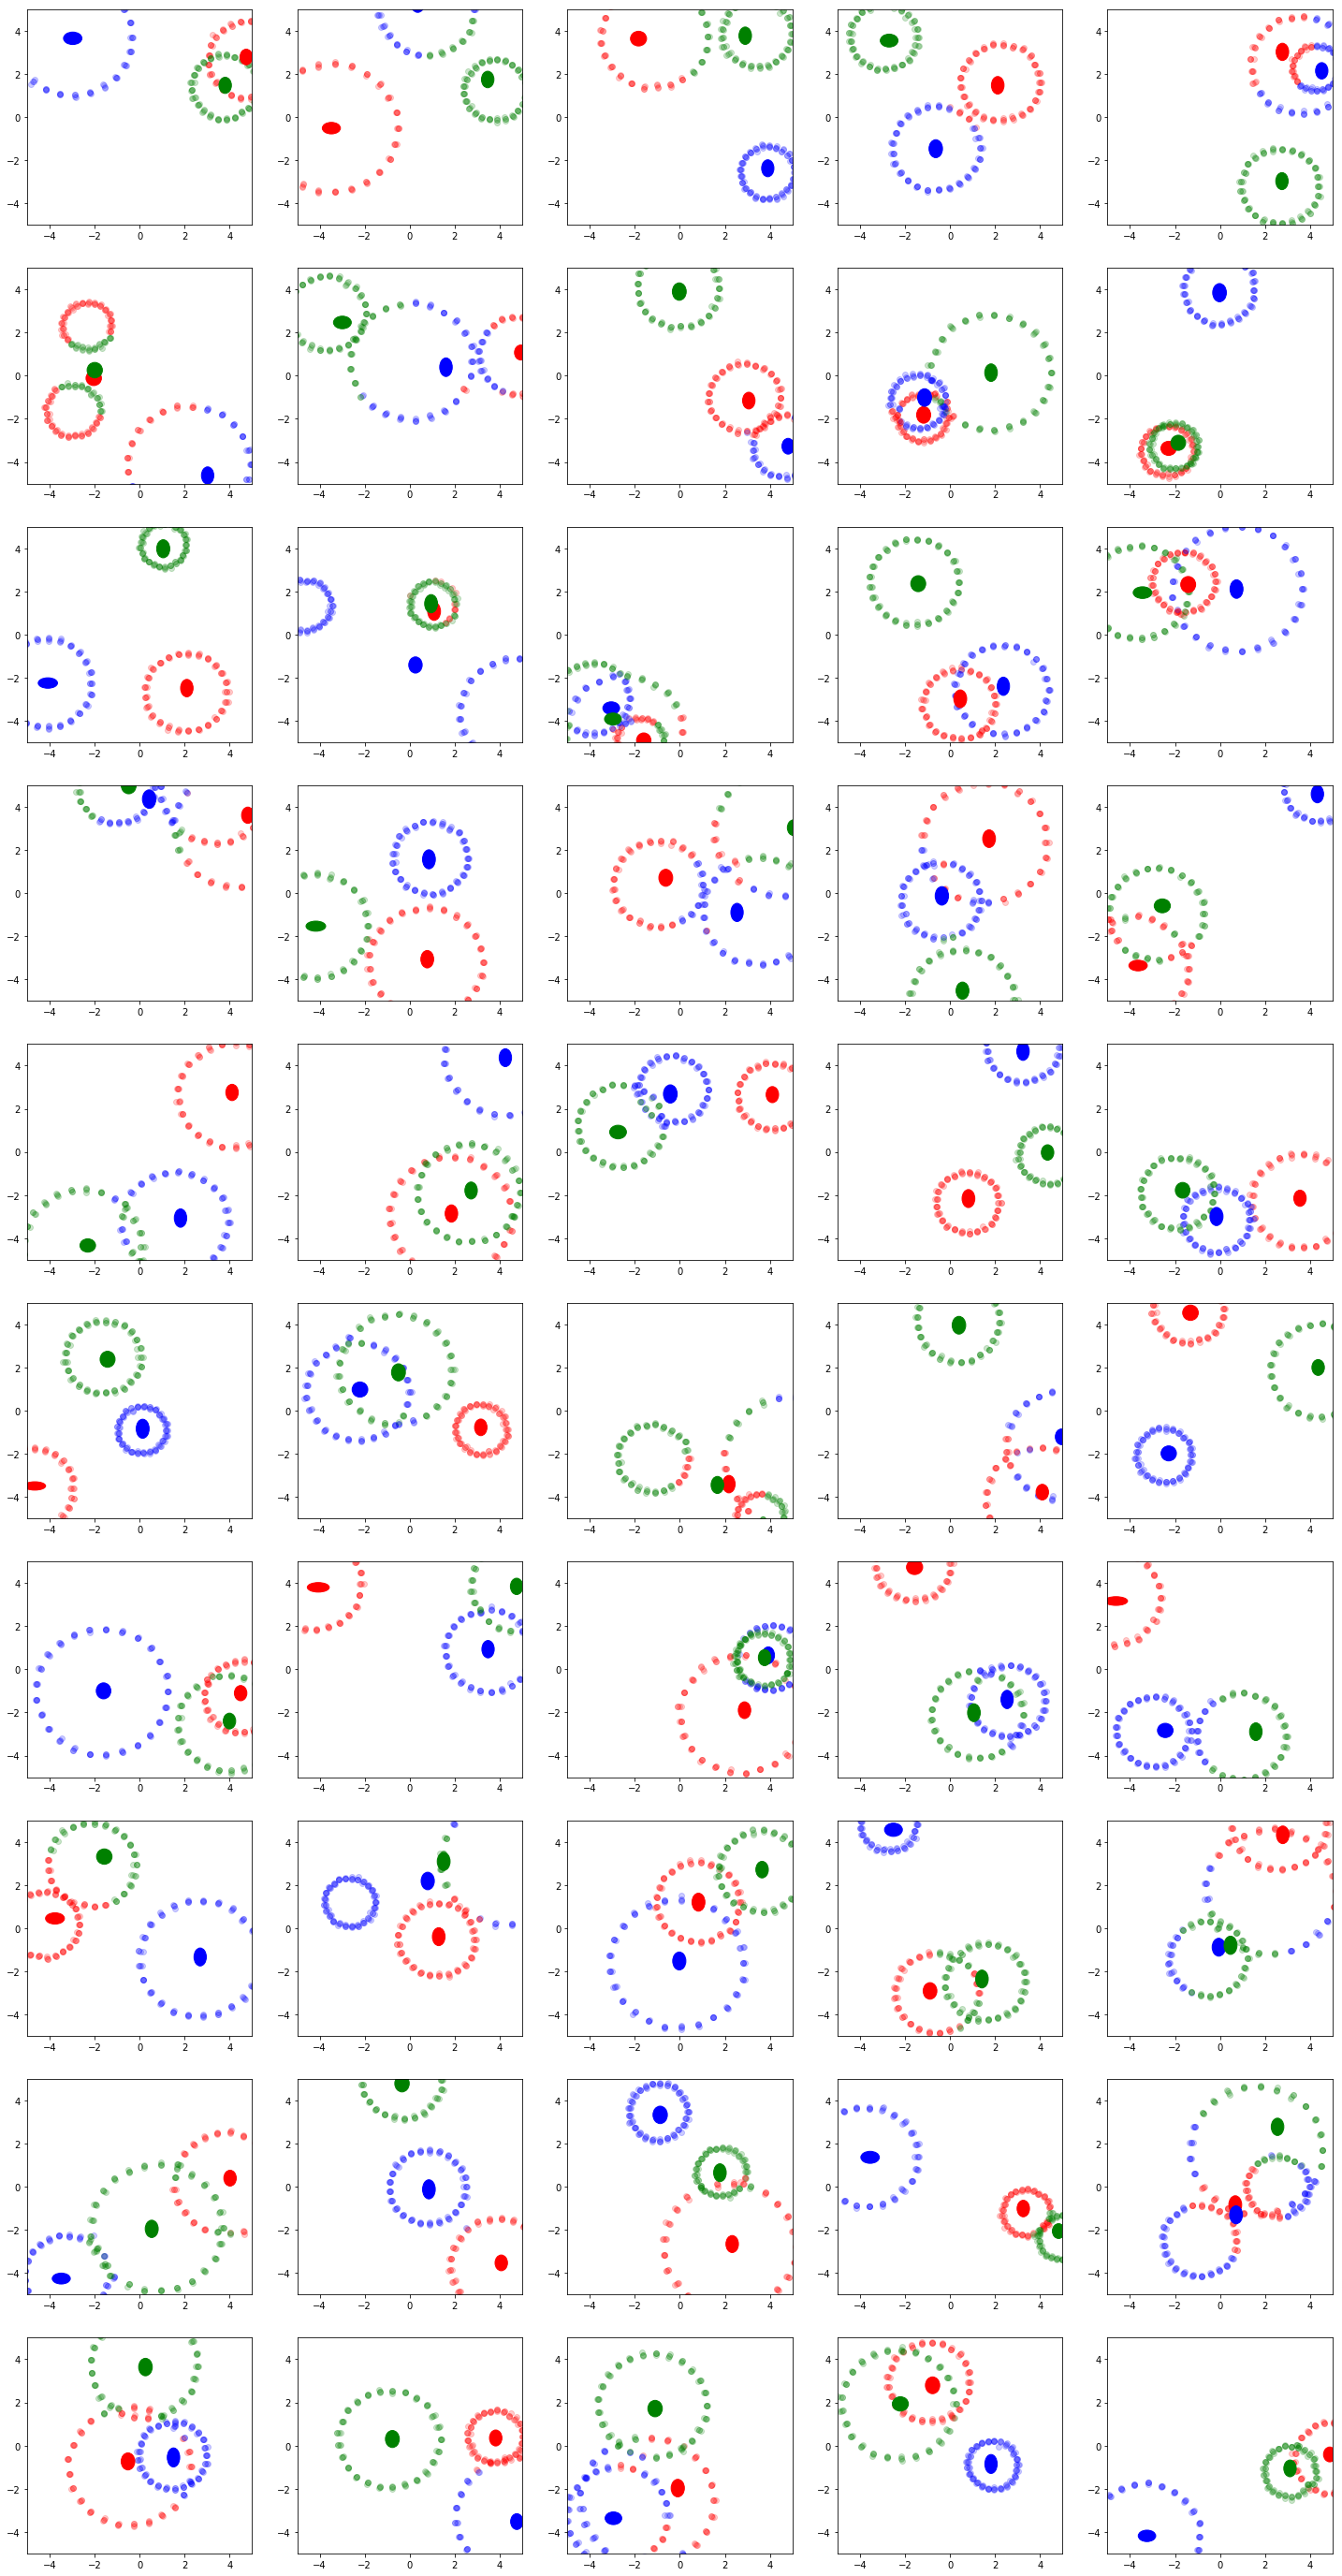

In [14]:
BATCH_SIZE_TEST = 50

def sample_single_batch(num_seqs, Xs, OBS_RAD, sample_size, batch_size, gpu):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    obs_rad = OBS_RAD[batch_indices].repeat(sample_size, 1, 1, 1)
    obs = shuffler(obs).repeat(sample_size, 1, 1, 1)
    if CUDA:
        obs = obs.cuda().to(gpu)
        obs_rad = obs_rad.cuda().to(gpu)
    return obs, obs_rad

def test(enc_mu, enc_z, obs, obs_rad, N, K, D, mcmc_size, sample_size, batch_size, gpu, noise_sigma=0.1):
    p_init_z = cat(prior_pi)
    states = p_init_z.sample((sample_size, batch_size, N,))
    log_p_z = p_init_z.log_prob(states)## S * B * N
    log_q_z = p_init_z.log_prob(states)
    for m in range(mcmc_size):
        q_mu, p_mu = enc_mu(obs, states, sample_size, batch_size)
        log_q_mu = q_mu['means'].log_prob.sum(-1)
        log_p_mu = p_mu['means'].log_prob.sum(-1) # S * B * K
        obs_mu = q_mu['means'].value
        log_obs_k = True_Log_likelihood(obs, states, obs_mu, obs_rad, K, D, noise_sigma=noise_sigma, gpu=gpu, cluster_flag=True)
        log_weights_global = log_obs_k + log_p_mu - log_q_mu
        weights_global = F.softmax(log_weights_global, 0).detach()
        ## resample mu
        obs_mu = resample_mu(obs_mu, weights_global)
        ## update z -- cluster assignments
        q_z, p_z = enc_z(obs, obs_mu, obs_rad, sample_size, batch_size, noise_sigma)
        log_p_z = p_z['zs'].log_prob
        log_q_z = q_z['zs'].log_prob ## S * B * N
        states = q_z['zs'].value
    return q_mu, q_z

def plot_samples(obs, q_eta, q_z, K, batch_size, PATH):
    colors = ['r', 'b', 'g']
    fig = plt.figure(figsize=(25,50))
    xs = obs[0].cpu()
    mu_mu = q_eta['means'].dist.loc[0].cpu().data.numpy()
    mu_sigma = q_eta['means'].dist.scale[0].cpu().data.numpy()
    zs = q_z['zs'].dist.probs[0].cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b]
        z = zs[b]
        mu_mu_b = mu_mu[b]
        mu_sigma_b = mu_sigma[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(mu_sigma_b[k]**2)
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
            plot_cov_ellipse(cov=cov_k, pos=mu_mu_b[k], nstd=2, ax=ax, alpha=1.0, color=colors[k])
        ax.set_ylim([-5, 5])
        ax.set_xlim([-5, 5])
    plt.savefig('results/modes-' + PATH + '.svg')
    
obs, obs_rad = sample_single_batch(NUM_SEQS, Xs, OBS_RAD, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
q_mu, q_z = test(enc_mu, enc_z, obs, obs_rad, N, K, D, 500, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
%time plot_samples(obs, q_mu, q_z, K, BATCH_SIZE_TEST, PATH)